# Data Science 325

## Learning Goal  
The goal of this notebook is to get hands-on experience and intuition about linear regression and regularization. We once again emphasize the difference between fitting and predicting. We will see that it is much more difficult to get good out-of-sample performance on a test set (predicting) than it is to get good in-sample performance on the training set (fitting).


## Least squares linear regression: 

For ordinary least square regression (no regularization), we minimize the square loss cost function:

$$
\operatorname{min} J(\theta) = \operatorname{min} ||X \theta-\textbf{y}||_2^2 = \operatorname{min} (X \theta-y)^T(X \theta-y)
$$

If features $X$ are linearly independent, then there exists unique solution to this problem:

$$
\hat{\theta}= (X^T X)^{-1} X^T y
$$

## Ridge Regression
In Ridge-Regression, the regularization penalty is taken to be the L2-norm of the parameters

$$
\operatorname{min} J_{ridge}(\theta) = \operatorname{min} ||X \theta-y||_2^2 + \alpha ||\theta||_2^2
$$

Notice that the parameter $\alpha$ controls how much we weigh the fit and regularization term.

## LASSO ##

We will also be interested in the case where the penalty is the L1-norm of the parameters (sum of absolute values of parameters). This is called LASSO.

$$
\operatorname{min} J_{lasso}(\theta) = \operatorname{min} ||X \theta-y||_2^2 + \alpha ||\theta||_1
$$

As we discussed in class, LASSO tends to give sparse solution. Below, we're going to explore these ideas a little bit more.


## load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.axes_style("whitegrid")
sns.set_context("paper")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Read in our dataset.

Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.

In [2]:
# Load Advertising dataset
web_path = 'http://public.gettysburg.edu/~jpuckett/ds325/data/' #if using data over web
df = pd.read_csv(web_path+'auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


.describe() generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [3]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


The mean value for mpg is is 23.5. 

.info() prints a concise summary of a DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


### Attribute Information:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

There are actually some 'junk' values in horsepower

In [5]:
temp = pd.DataFrame(df.horsepower.str.isdigit())
temp[temp['horsepower']==False]#these are the rows that don't have numerical values for horsepower

,horsepower
32,False
126,False
330,False
336,False
354,False
374,False


Check to see these non-numeric entries.

In [6]:
df[df['horsepower'].str.isnumeric()==False]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


Lets replace those with NaN (not a number).

In [7]:
df=df.replace('?',np.nan)

Now there are 'many' things we can do with the NaN values (like replace with the median or mean).  Here, I'd prefer to drop the rows altogether.  

We only lose 6 rows of data.

In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 30.6+ KB


In [9]:
# convert horsepower from strings to float
df['horsepower']=df['horsepower'].astype('float')

## Look for Correlations

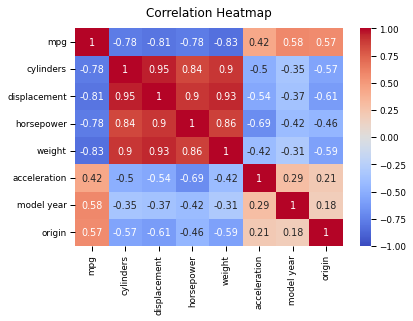

In [10]:
heatmap = sns.heatmap(df.corr(), annot=True,vmin=-1,vmax=1,cmap='coolwarm')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

There are strong correlations between **cylinders**, **displacement** and **weight**.  Additionally, each of these dependent variables have strong negative correlation with the dependent variable **mpg**.  Our end model should keep this in mind.

We can also see pairplot (and histograms) for each variable in the dataset.  

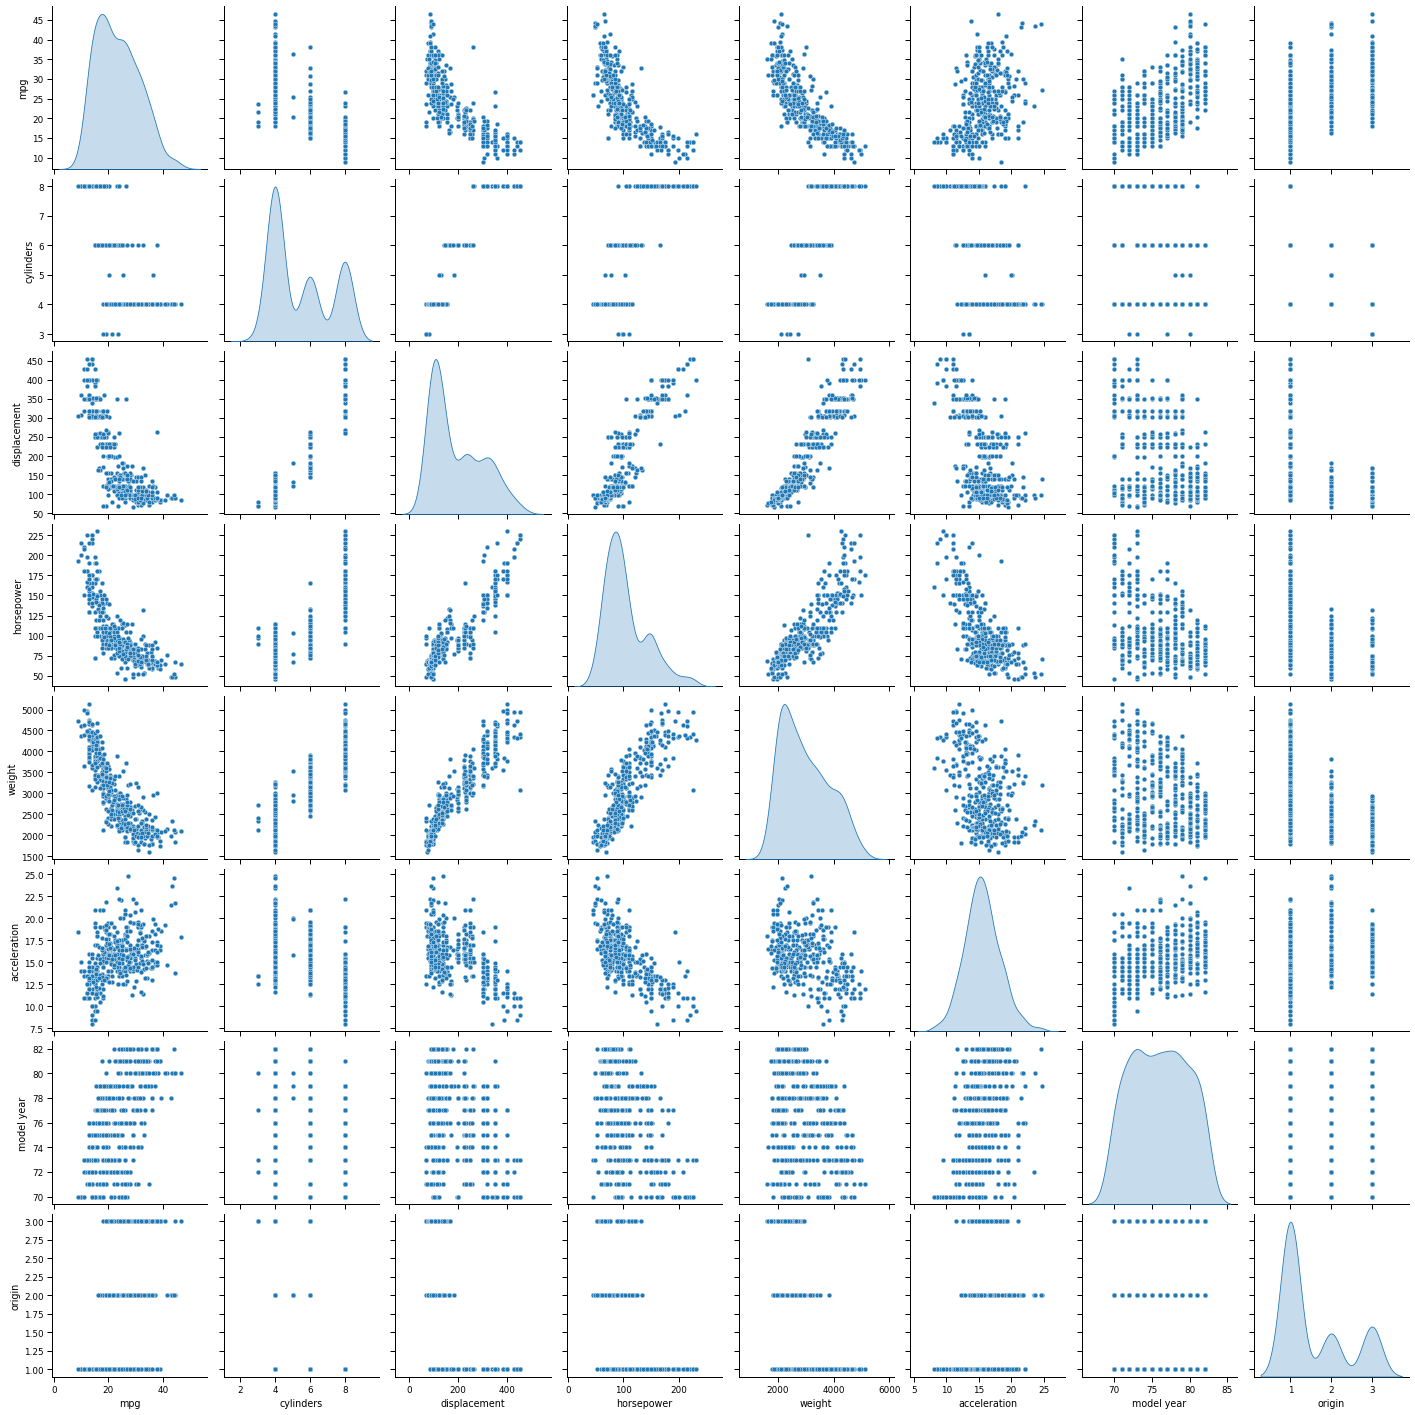

In [11]:
sns.pairplot(df, diag_kind='kde');

Cylinders and origin only have discrete values.  

# Non-linear regression intro
Before we dive into how to deal with the strong correlations with our independent variables, lets focus on the **weight** number (x) and **mpg** (y).  From the above table we see the two are clearly (negatively) correlated.

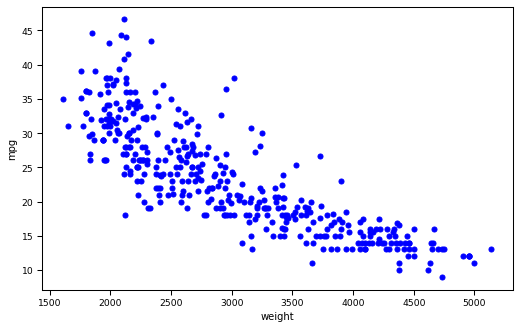

In [12]:
# Variables
x = np.array(df['weight']) #convert into a numpy array 
features = df.columns
y = np.array(df['mpg'])
fig = plt.figure(figsize = (8.1,5),dpi=75)
plt.plot(x,y,'bo')
plt.xlabel('weight')
plt.ylabel('mpg')
plt.show()

## prepare our data

$ y = \theta X$
$ X = [1 1/x]$
$ y = \theta_0 *1 + \theta_1 * 1/x$

In [13]:
X_b = np.c_[np.ones(x.shape),1./x] #add a column of ones to our x
theta_ls = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) #
print('theta0 = %5f'%theta_ls[0]) 
print('theta1 = %5f'%theta_ls[1]) 

theta0 = -0.508256
theta1 = 65953.347714


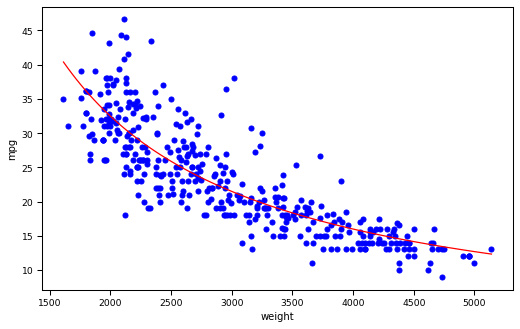

In [14]:
xx = np.linspace(np.min(x),np.max(x),100)
yy = theta_ls[0]+theta_ls[1]/xx
fig = plt.figure(figsize = (8.1,5),dpi=75)
plt.plot(x,y,'bo')
plt.plot(xx,yy,'r-')
plt.xlabel('weight')
plt.ylabel('mpg')
plt.show()

## compare with curve_fit

In [15]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize
# your model definition
def f(x, a, b):
    return a+b/x
# do the fit with some initial values
theta_cf, pcov = curve_fit(f, x, y, p0=(1, 1))
print('theta0 = %5f'%theta_cf[0])
print('theta1 = %5f'%theta_cf[1])

theta0 = -0.508256
theta1 = 65953.349940


We can see these are exactly the same fits.

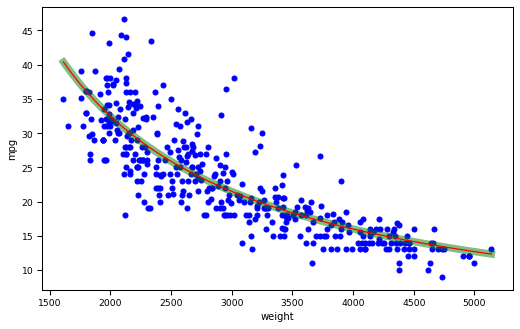

In [16]:
yyf = theta_cf[0]+theta_cf[1]/xx
fig = plt.figure(figsize = (8.1,5),dpi=75)
plt.plot(x,y,'bo')
plt.plot(xx,yy,'g-',lw=7,alpha=0.5)
plt.plot(xx,yy,'r-')
plt.xlabel('weight')
plt.ylabel('mpg')
plt.show()

# Linear regression

Let's use a linear model to fit **mpg** with each of our independent variables.

In [17]:
df2=df.drop('car name',axis=1)
X = df2.drop(['mpg'], axis = 1).astype('float64')
y = df[['mpg']]

split the data into training and test dataset

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=1) #

run the regression and print the coefficient for all independent variables

In [19]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print("Linear")
for idx, col in enumerate(X_train.columns):
    print("Coefficient:  %s  \t=  %4f"%(col, linear_model.coef_[0][idx]))

Linear
Coefficient:  cylinders  	=  -0.205978
Coefficient:  displacement  	=  0.019639
Coefficient:  horsepower  	=  -0.001616
Coefficient:  weight  	=  -0.007283
Coefficient:  acceleration  	=  0.281866
Coefficient:  model year  	=  0.742798
Coefficient:  origin  	=  1.380904


Lets check the accuracy of the model.

In [20]:
print("The accuracy of the model is %3.3f"%(linear_model.score(X_test,y_test)))

The accuracy of the model is 0.822


# Ridge regression

The Ridge() function has an alpha argument ( $\alpha$ , but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [21]:
alphas = np.logspace(-3,5,100)

In [22]:
ridge = Ridge(normalize = True)
coefs = []
mses = []

for a in alphas:
    ridge.set_params(alpha = a) #alpha
    ridge.fit(X_train, y_train) #fit
    coefs.append(ridge.coef_)    #save coefficients
    pred = ridge.predict(X_test)  #find predicitions
    mses.append(mean_squared_error(y_test, pred) ) #save the MSE
#
coefs = np.array(coefs).reshape(alphas.shape[0],-1)
mses = np.array(mses).reshape(alphas.shape[0],-1)

We expect the coefficient estimates to be much smaller, in terms of  l2  norm, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

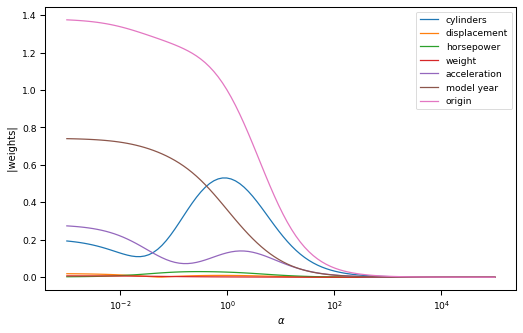

In [23]:
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, np.abs(coefs))
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(' |weights| ')
plt.legend(features)
plt.legend(X.columns)
plt.show()

Lets view the $MSE$ score for each model.

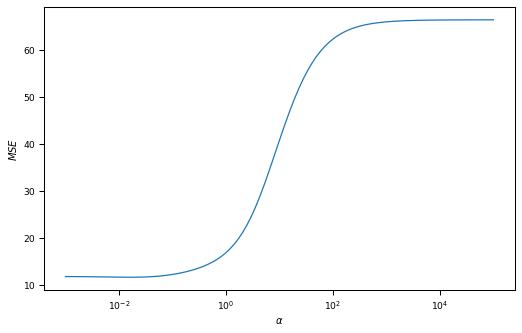

In [24]:
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, mses)
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$MSE$')
plt.show()

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\alpha=10$:

In [25]:
ridge2 = Ridge(alpha = 10,normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_[0], index = X.columns)) # Print coefficients
print("R2  = %4f"%(ridge2.score(X_test,y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred2))   

cylinders      -0.232467
displacement   -0.004050
horsepower     -0.010721
weight         -0.000522
acceleration    0.079855
model year      0.088485
origin          0.360145
dtype: float64
R2  = 0.385722
MSE = 40.839346


Now let's see what happens if we use a huge value of alpha, say  $10^5$:

In [26]:
ridge3 = Ridge(alpha = 10**5)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_[0], index = X.columns)) # Print coefficients
print("R2  = %4f"%(ridge3.score(X_test,y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred3))         

cylinders      -0.000212
displacement   -0.009736
horsepower     -0.019393
weight         -0.005547
acceleration    0.003022
model year      0.023353
origin          0.001372
dtype: float64
R2  = 0.732651
MSE = 17.774291


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

How does the ridge regression with $\alpha=10$ do better than regular least squares ( $\alpha=0$ )?

In [27]:
ridge4 = Ridge(alpha = 0)
ridge4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred4 = ridge4.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge4.coef_[0], index = X.columns)) # Print coefficients
print("R2  = %4f"%(ridge4.score(X_test,y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred4))      

cylinders      -0.205978
displacement    0.019639
horsepower     -0.001616
weight         -0.007283
acceleration    0.281866
model year      0.742798
origin          1.380904
dtype: float64
R2  = 0.822289
MSE = 11.814844


Instead of hunting around for the _best_ $\alpha$, it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV(). 

In [28]:
### nice function to find best alpha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
print("alpha_best = %4f"%ridgecv.alpha_)

alpha_best = 15.922828


In [29]:
ridge4 = Ridge(alpha = ridgecv.alpha_)
ridge4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred4 = ridge4.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge4.coef_[0], index = X.columns)) # Print coefficients
print("R2  = %4f"%(ridge4.score(X_test,y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred4)) 

cylinders      -0.148479
displacement    0.017294
horsepower     -0.000454
weight         -0.007281
acceleration    0.271938
model year      0.740037
origin          1.193171
dtype: float64
R2  = 0.822075
MSE = 11.829042


# Lasso regression

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the Lasso() function; however, this time we'll need to include the argument max_iter = 10000. 

We will also need to use **scale** on our **X** data.  
* scale normalizes the variable so that we can explore the relative strength of each parameter
* this helps us choose a model, but the coefficients no longer have interpretability
* after choosing a model, re-run with best **$\alpha$** without scaling


Other than that, we proceed just as we did in fitting a ridge model:

In [30]:
lasso = Lasso(max_iter = 500)
coefs = []
mses = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    pred = lasso.predict(scale(X_test))
    mses.append(mean_squared_error(y_test, pred) )
#
coefs = np.array(coefs).reshape(alphas.shape[0],-1)
mses = np.array(mses).reshape(alphas.shape[0],-1)

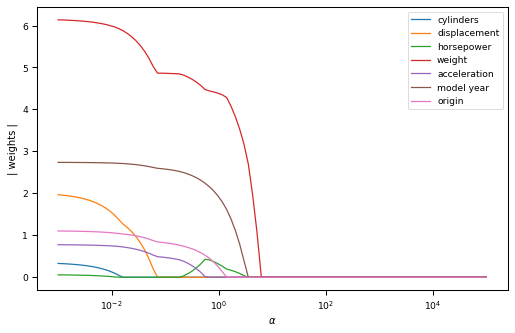

In [31]:
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, np.abs(coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel(r'$\alpha$')
plt.ylabel('| weights |')
plt.legend(X.columns)
plt.show()

Lets view the $MSE$ score for each model.

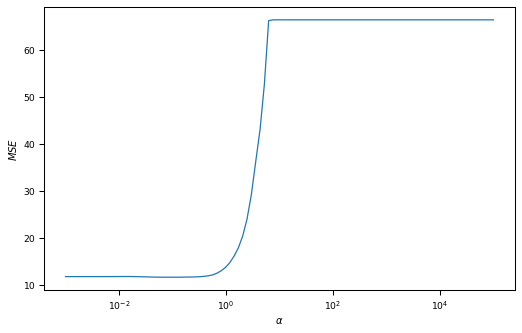

In [32]:
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, mses)
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$MSE$')
plt.show()

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [33]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(scale(X_train), np.ravel(y_train))
print("alpha_best = %4f"%lassocv.alpha_)

alpha_best = 0.022095


In [34]:
##now use this alpha to train a model
lasso.set_params(alpha=lassocv.alpha_)
pred5 = lassocv.predict(scale(X_test))
print(pd.Series(lassocv.coef_, index = X.columns)) # Print coefficients
print("R2  = %4f"%(lassocv.score(scale(X_test),y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred5)) 

cylinders      -0.000000
displacement    1.126058
horsepower     -0.000000
weight         -5.765387
acceleration    0.695734
model year      2.697703
origin          1.010395
dtype: float64
R2  = 0.823423
MSE = 11.739478


We see that this model only uses about 5 non-zeros coefficients for **displacement**, **weight**, **acceleration**, **origin** and **model year**.  Note, the model complexity is lower than OLS (7 coefficients).